# Introduction

In the following notebook, I will be analyzing patient data from the UCI Heart Disease [Dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease). This dataset contains heart health information of patients diagnosed with/without heart disease. 

Note: This dataset originally had 75 attributes. Due to data corruption issues, only 14 attributes remain. 

In this notebook, I will be performing the following:
- Exploratory Data Analysis using Seaborn and Matplotlib
- AUC/ROC, Confusion Matrix
- Stratified K-Fold Cross Validation
- Hyperparamter optimization using Random and Grid Search techniques
- Creating a classifier
- Machine learning Pipeline

Let's begin.

**Load Libraries and Read in Data**

In [251]:
# Read in Libraries
import pandas_profiling
import pandas as pd

import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
#Import warnings filter
from warnings import simplefilter

#Ignore future warnings
simplefilter(action='ignore', category=FutureWarning)

#Set Plot Style for Notebook
sns.set(style="whitegrid")

In [252]:
#Read in Data
df = pd.read_csv("heart.csv")

# Data Preview

 **Variable Description**

UCI and Kaggle datasets reflect incorrect variable information, utilizing data dictionary corrections provided [here](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005).

 age: The person's age in years

 sex: The person's sex (1 = male, 0 = female)

 cp: The chest pain experienced (Value 0: asymptomatic, Value 1: atypical angina,Value 2: non-anginal pain, Value 3: typical angina)

 trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)

 chol: The person's cholesterol measurement in mg/dl

 fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

 restecg: Resting electrocardiographic measurement (0 = showing probable or definite left ventricular hypertrophy by Estes' criteria,  1 = normal,  2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))

 thalach: The person's maximum heart rate achieved

 exang: Exercise induced angina (1 = yes; 0 = no)

 oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)

 slope: slope: the slope of the peak exercise ST segment (0 = downsloping,  1 = flat,  2 = upsloping)

 ca: The number of major vessels (0-3)

 thal: A blood disorder called thalassemia (1 = fixed defect, 2 = normal, 3 = reversable defect)

 target: Heart disease (0 = disease, 1 = no disease)

In [253]:
#Create Pandas Profiling Report
#profile = df.profile_report(title='Pandas Profiling Report')

#Print Report
#profile

#Create html file of Profile Report
#profile.to_file(output_file="Heart Disease Pandas Report.html")

# Data Cleaning

Remove duplicate rows

In [254]:
#Drop duplicate rows
df.drop_duplicates(inplace = True)

Remove rows containing anomalies in **ca** and **thal** columns

In [255]:
#Remove ca anomalies
df.drop(df[df['ca'] == 4].index, inplace=True)

#Remove thal anomalies
df.drop(df[df['thal'] == 0].index, inplace=True)

Update column headers with more informative names

In [256]:
#New column names
names= ['Age', 'Sex', 'Chest_Pain', 'Rest_BP', 'Cholesterol', 'FBS_Over_120mg/dl',
        'Rest_EKG', 'Max_HR', 'Exercise_Induced_Angina','ST_Depression', 
        'ST_Slope', 'Num_Major_Vessels', 'Thalassemia', 'Target']

#Assign Names
df.columns = names

Due to data corruption issues, updating categorical values in the dataset as defined by updated [data dictionary](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877#latest-650005)

Also updating the Target. Presently, a 1 as a target signifies that the patient is healthy while 0 signifies the patient has heart disease. Resersing(for my sanity and yours)

In [257]:
#Update Chest_Pain
df.loc[df['Chest_Pain'] == 0, 'Chest_Pain'] = 'Asymptomatic'
df.loc[df['Chest_Pain'] == 1, 'Chest_Pain'] = 'Atypical Angina'
df.loc[df['Chest_Pain'] == 2, 'Chest_Pain'] = 'Non-anginal Pain'
df.loc[df['Chest_Pain'] == 3, 'Chest_Pain'] = 'Typical Angina'


#Update Resting_ECG
df.loc[df['Rest_EKG'] == 0, 'Rest_EKG'] = 'Left ventricular hypertrophy'
df.loc[df['Rest_EKG'] == 1, 'Rest_EKG'] = 'Normal'
df.loc[df['Rest_EKG'] == 2, 'Rest_EKG'] = 'ST-T wave abnormality'


#Update ST_Slope
df.loc[df['ST_Slope'] == 0, 'ST_Slope'] = 'Downsloping'
df.loc[df['ST_Slope'] == 1, 'ST_Slope'] = 'Flat'
df.loc[df['ST_Slope'] == 2, 'ST_Slope'] = 'Upsloping'


#Update Thalassemia
df.loc[df['Thalassemia'] == 1, 'Thalassemia'] = 'Fixed defect'
df.loc[df['Thalassemia'] == 2, 'Thalassemia'] = 'Normal'
df.loc[df['Thalassemia'] == 3, 'Thalassemia'] = 'Reversable defect'

#Update Target (0 means disease while 1 means healthy, reversing)
df.Target = df.Target.apply(lambda x: 0 if x == 1 else 1)

In [258]:
df.groupby('Target').size()

Target
0    160
1    136
dtype: int64

Create dummy variables for categorical variables and assign to dummies data frame. Reorganize column order such that **target** is at index 0.

In [259]:
#Create dummy variables for categorical variables
dummies = pd.get_dummies(df)

#Create list of column headers 
cols = dummies.columns.to_list()

#Move Target to front of cols
cols.insert(0, cols.pop(cols.index('Target')))

#Reindex dummies with cols 
dummies = dummies.reindex(columns= cols)

Check dummies to confirm all categorical datas have been converted properly.

In [260]:
#Display all columns of df
pd.set_option('display.max_columns', 35)

#Missed Num_Major_Vessels
dummies = pd.get_dummies(dummies, columns=['Num_Major_Vessels'])

#Check
dummies.head()

,Target,Age,Sex,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Max_HR,Exercise_Induced_Angina,ST_Depression,Chest_Pain_Asymptomatic,Chest_Pain_Atypical Angina,Chest_Pain_Non-anginal Pain,Chest_Pain_Typical Angina,Rest_EKG_Left ventricular hypertrophy,Rest_EKG_Normal,Rest_EKG_ST-T wave abnormality,ST_Slope_Downsloping,ST_Slope_Flat,ST_Slope_Upsloping,Thalassemia_Fixed defect,Thalassemia_Normal,Thalassemia_Reversable defect,Num_Major_Vessels_0,Num_Major_Vessels_1,Num_Major_Vessels_2,Num_Major_Vessels_3
0,0,63,1,145,233,1,150,0,2.3,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
1,0,37,1,130,250,0,187,0,3.5,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
2,0,41,0,130,204,0,172,0,1.4,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0
3,0,56,1,120,236,0,178,0,0.8,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,57,0,120,354,0,163,1,0.6,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0


# Exploratory Data Analysis

Let's begin by taking a look at the correlation matrix and heatmap

In [261]:
#Compute correlation matrix
corr = dummies.corr()

print(corr.Target.sort_values(ascending=False).head(5))

print(corr.Target.sort_values(ascending=False).tail(5))

Target                           1.000000
Chest_Pain_Asymptomatic          0.505149
Thalassemia_Reversable defect    0.489046
ST_Depression                    0.428804
Exercise_Induced_Angina          0.425085
Name: Target, dtype: float64
Chest_Pain_Non-anginal Pain   -0.303870
ST_Slope_Upsloping            -0.386007
Max_HR                        -0.426655
Num_Major_Vessels_0           -0.488146
Thalassemia_Normal            -0.530032
Name: Target, dtype: float64


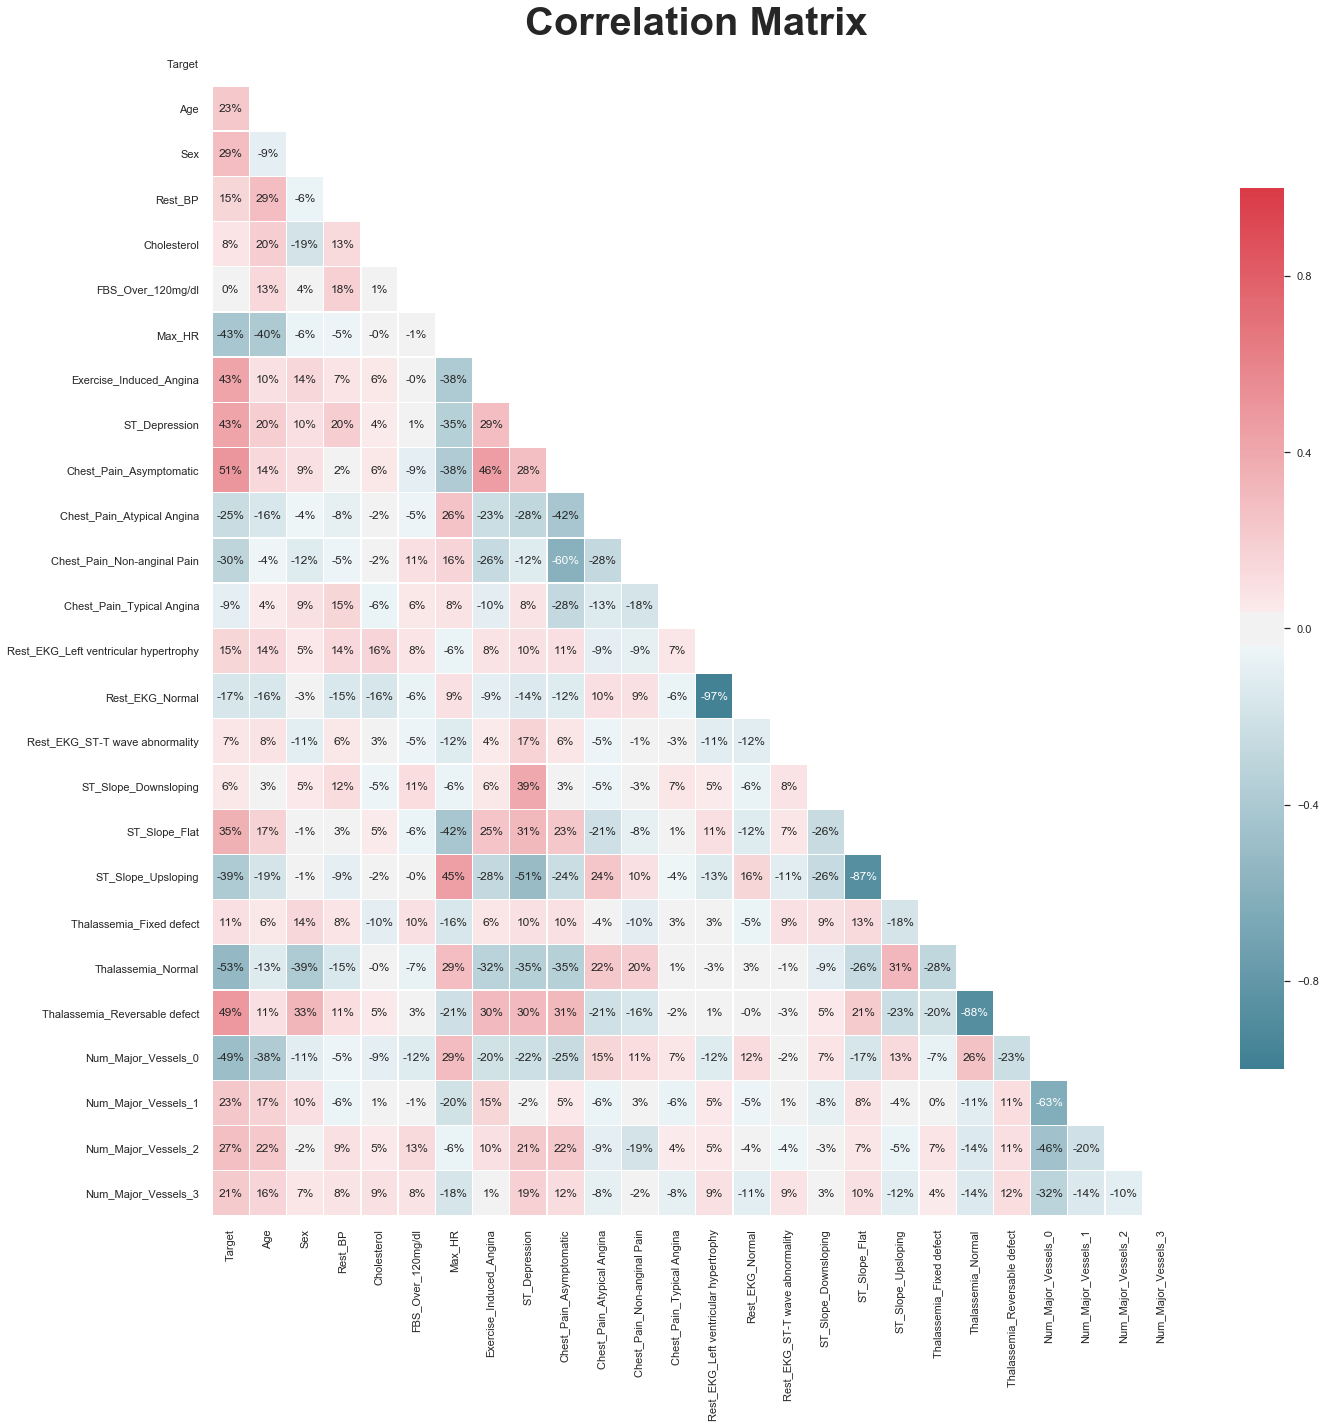

In [262]:
#Set figure size
fig, ax = plt.subplots(figsize=(20,20))

#Generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

#Create custom cmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Plot heatmap
g = sns.heatmap(corr, vmin=-1, vmax=1, center = 0,mask=mask,
               linewidth = .25, annot=True,fmt='.0%',
                cbar_kws={"shrink":.75},
               cmap= cmap, ax=ax)

#Set plot title
ax.set_title('Correlation Matrix', fontsize = 40, fontweight='heavy');

#plt.savefig("Correlation Matrix.png", dpi = 1080)

fig.tight_layout()

**Rates of Heart Disease between Men and Women**



In [263]:
print(df.groupby(['Sex','Target'])['Target'].size())

Sex  Target
0    0          71
     1          24
1    0          89
     1         112
Name: Target, dtype: int64


Heart Disease counts by gender:
Sex  Target
0    0          71
     1          24
1    0          89
     1         112
Name: Target, dtype: int64


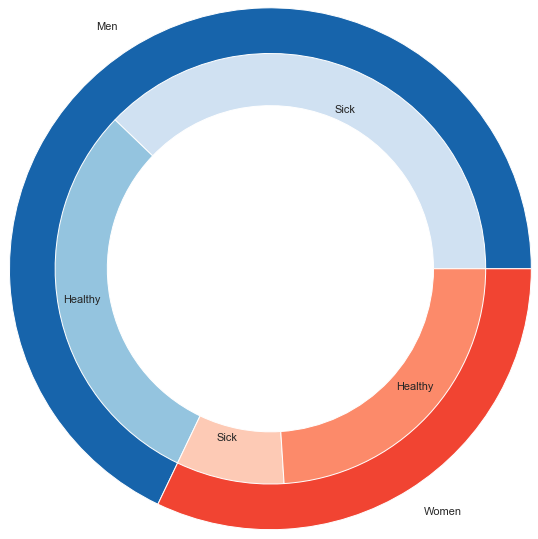

In [264]:
#Print heart disease counts by Sex(0=disease, 1= no disease)
print('Heart Disease counts by gender:')
print(df.groupby(['Sex','Target'])['Target'].size())

# Make data: I have 2 groups and 4 subgroups
group_names=['Men', 'Women']
group_size=[201,95]
subgroup_names=['Sick', 'Healthy', 'Sick', 'Healthy']
subgroup_size=[112,89,24,71]
 
# Create colors
Men, Women =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(6,6))

ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=2, labels=group_names, colors=[Men(0.8), Women(0.6)])

plt.setp(mypie, width=0.6, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=2-0.35, labels=subgroup_names, 
                   labeldistance=0.8, rotatelabels =0,
                   colors=[Men(0.2), Men(0.4), Women(0.2), Women(0.4)])

plt.setp(mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

#Set Title


# show it
plt.show()


In our dataset, men outnumber women by quite a bit. However, the proportion of sick to healthy individuals between the sexes is very interesting but not super surprising. We do know that men are more likely to suffer from heart related illnesses that women ([source](https://www.telegraph.co.uk/men/active/mens-health/11723374/Why-do-men-suffer-more-heart-problems-than-women.html)).

Let's take a look into some of the factors that contribute to heart disease, starting with patient blood pressure at the time of admittance to the hospital.

**Resting BP and Rates of Heart Disease by Gender**

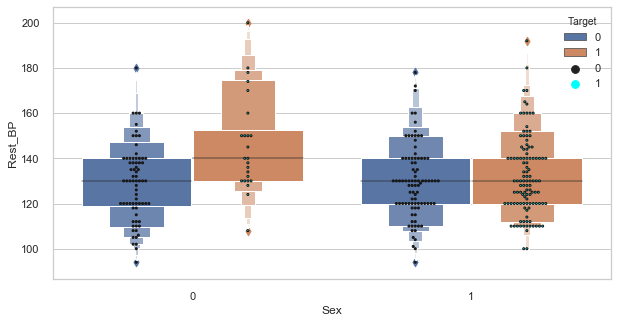

In [265]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

#Plot
g = sns.boxenplot(x='Sex', y='Rest_BP', hue = 'Target', 
                  #labels= ['No Disease', 'Disease'],
                  dodge=True,
                  data = df, ax=ax)

# Add in points to show each observation
sns.swarmplot(x="Sex", y="Rest_BP", hue ='Target', data=df,dodge=True,
              size=2, color="cyan", linewidth=1)
#Set Legend Labels
#g.legend(labels= ['No Disease', 'Disease'])

split below by gender

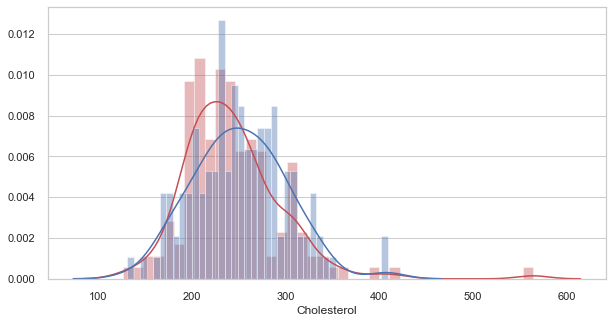

In [266]:
#plot
fig, ax = plt.subplots(figsize = (10,5))

#healthy
g = sns.distplot(df['Cholesterol'][df['Target'] == 0], bins = 40, 
                 color = 'r', ax=ax)

#diesease
k=sns.distplot(df['Cholesterol'][df['Target'] == 1], bins=40, 
               color = 'b', ax=ax)


#Mute vertical grid lines
ax.xaxis.grid()

Chest pain

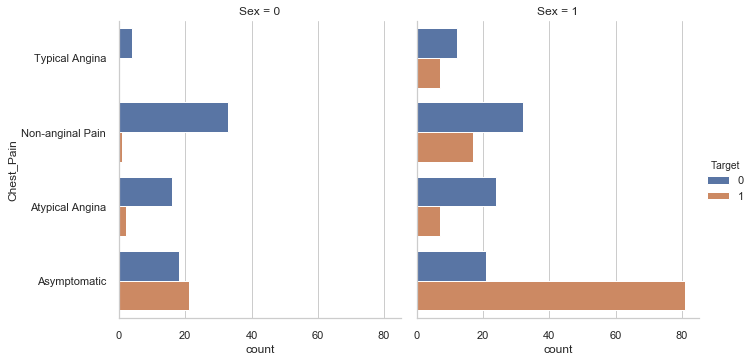

In [267]:
#Chest pain and disease for men and women
sns.catplot(y='Chest_Pain',col = 'Sex', hue='Target', 
            kind = 'count',data=df)

Most disease patients are asymptomatic for chestpain

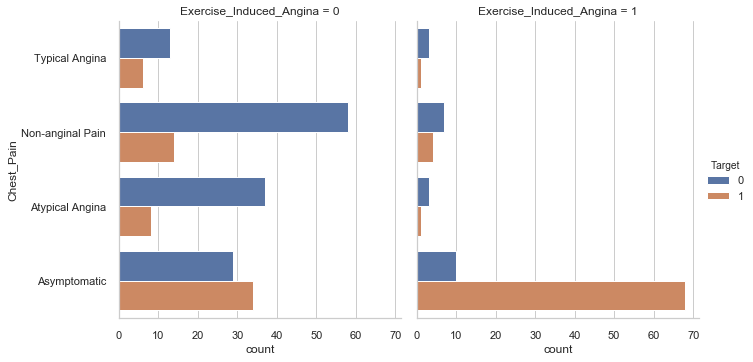

In [268]:
sns.catplot(y='Chest_Pain',col = 'Exercise_Induced_Angina', hue='Target', 
            kind = 'count',data=df)

# Let's look into the heart

Thalassmia

What is thalessmia?

Thalassemia is a blood disorder passed down through families (inherited) in which the body makes an abnormal form or inadequate amount of hemoglobin. Hemoglobin is the protein in red blood cells that carries oxygen. The disorder results in large numbers of red blood cells being destroyed, which leads to anemia.

What is Thalium? Nuclear stress testing requires the injection of a tracer, commonly technicium 99M (Myoview or Cardiolyte), which is then taken up by healthy, viable myocardial cells. A camera (detector) is used afterwards to image the heart and compare segments. A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. This is called a "reversible defect." Scarred myocardium from prior infarct will not take up tracer at all and is referred to as a "fixed defect.

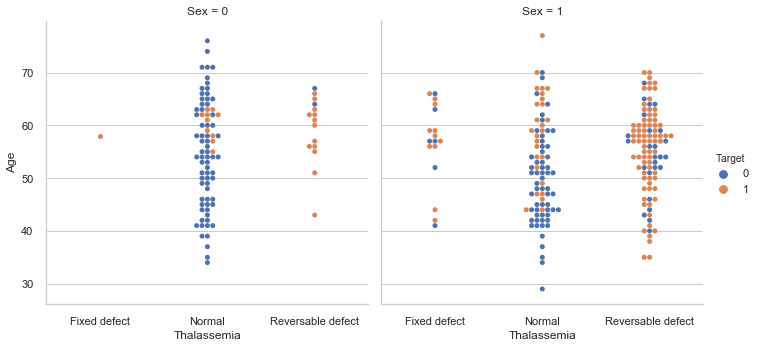

In [269]:
#sns.swarmplot(x='Thalassemia', y= 'Age',size = 5, hue='Target', data=df)
sns.catplot(x='Thalassemia', y= 'Age', hue='Target',
            col= 'Sex', 
            kind='swarm',data=df)

ST Slope

What is ST Depression?

ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline.
The ST Segment represents the interval between ventricular depolarization and repolarization.
**The most important cause of ST segment abnormality (elevation or depression) is myocardial ischaemia or infarction**

Morphology of ST Depression
ST depression can be either upsloping, downsloping, or horizontal (see diagram below).
Horizontal or downsloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischaemia (according to the 2007 Task Force Criteria).
ST depression ≥ 1 mm is more specific and conveys a worse prognosis.
ST depression ≥ 2 mm in ≥ 3 leads is associated with a high probability of NSTEMI and predicts significant mortality (35% mortality at 30 days).
Upsloping ST depression is non-specific for myocardial ischaemia.

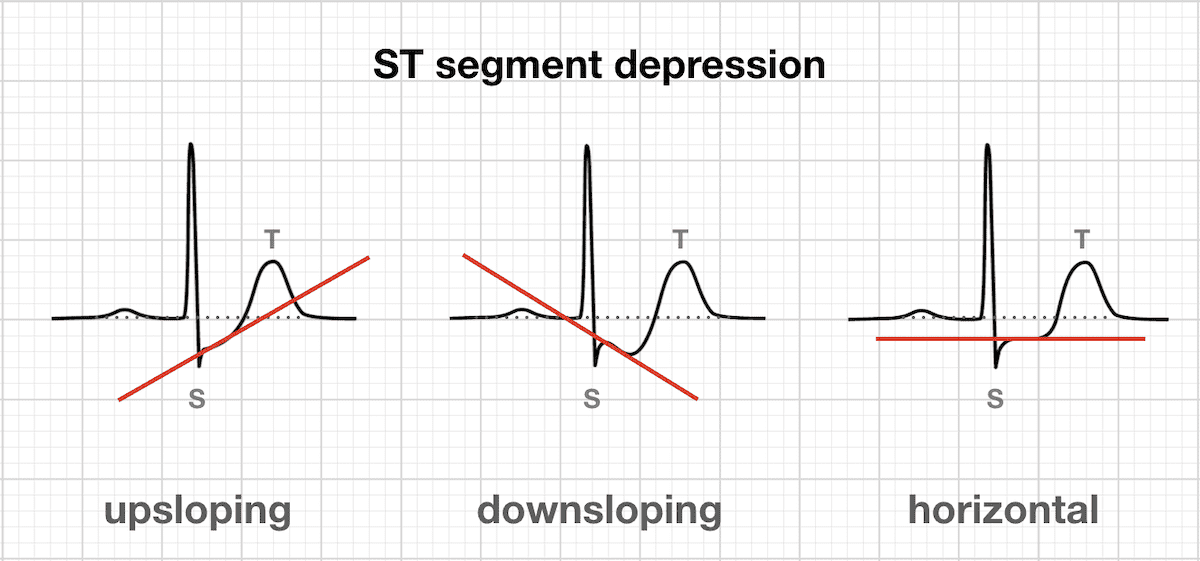

In [270]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "ST Slope.png", height=600, width =600)

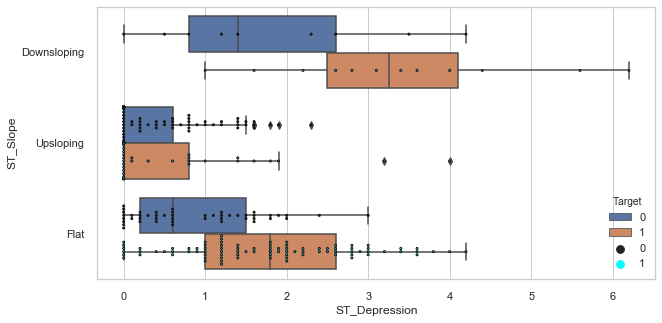

In [271]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

#Plot 
g=sns.boxplot('ST_Depression', 'ST_Slope', hue ='Target',
                data = df, ax=ax)

# Add in points to show each observation
sns.swarmplot(x="ST_Depression", y="ST_Slope", hue ='Target', data=df,
              size=2, color="cyan",dodge=True, linewidth=1)

Upsloping ST depression is non-specific for myocardial ischaemia.
Horizontal or downsloping ST depression ≥ 0.5 mm at the J-point in ≥ 2 contiguous leads indicates myocardial ischaemia (according to the 2007 Task Force Criteria)

# Maximum HR , slope and age

In [272]:
df.head(1)

,Age,Sex,Chest_Pain,Rest_BP,Cholesterol,FBS_Over_120mg/dl,Rest_EKG,Max_HR,Exercise_Induced_Angina,ST_Depression,ST_Slope,Num_Major_Vessels,Thalassemia,Target
0,63,1,Typical Angina,145,233,1,Left ventricular hypertrophy,150,0,2.3,Downsloping,0,Fixed defect,0


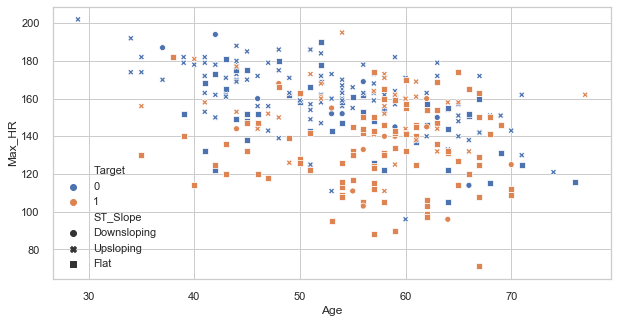

In [273]:
#Set Figure Size
fig, ax = plt.subplots(figsize = (10,5))

g=sns.scatterplot('Age', 'Max_HR', hue='Target', style='ST_Slope',sizes=5,
                  #size='Exercise_Induced_Angina',
                  y_jitter=True, x_jitter=True, data = df, ax=ax)

In [274]:
df.Rest_EKG

0      Left ventricular hypertrophy
1                            Normal
2      Left ventricular hypertrophy
3                            Normal
4                            Normal
                   ...             
298                          Normal
299                          Normal
300                          Normal
301                          Normal
302    Left ventricular hypertrophy
Name: Rest_EKG, Length: 296, dtype: object

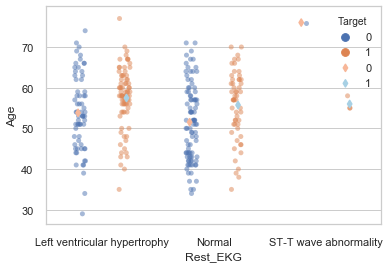

In [275]:
sns.stripplot('Rest_EKG', 'Age',hue='Target', 
              dodge=True, jitter=True,
              alpha=.5, zorder=1,
              data=df)

# Show the conditional means
sns.pointplot('Rest_EKG', 'Age',hue='Target',
              data=df, dodge= .434, join=False, palette="RdBu",
              markers="d", scale=.75, ci=None)

Fluoroscopy

Fluoroscopy is a study of moving body structures--similar to an X-ray "movie." A continuous X-ray beam is passed through the body part being examined. The beam is transmitted to a TV-like monitor so that the body part and its motion can be seen in detail. 

Fluoroscopy may be performed to evaluate specific areas of the body, including the bones, muscles, and joints, as well as solid organs, such as the heart, lung, or kidneys.

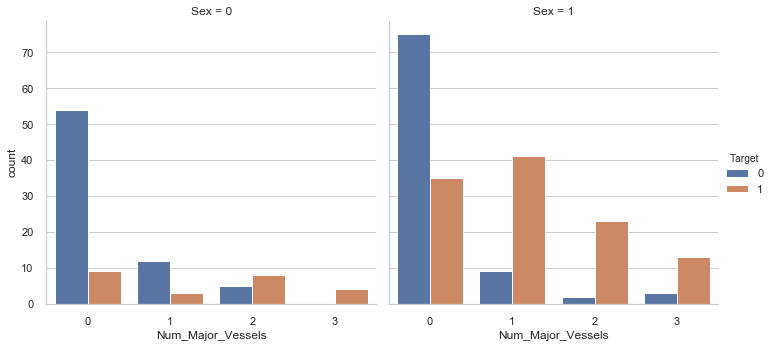

In [276]:
sns.catplot('Num_Major_Vessels', kind='count', col='Sex',hue= 'Target', 
           data=df)

# Machine Learning

### Data Preprocessing

View feature distributions for data preprocessing purposes

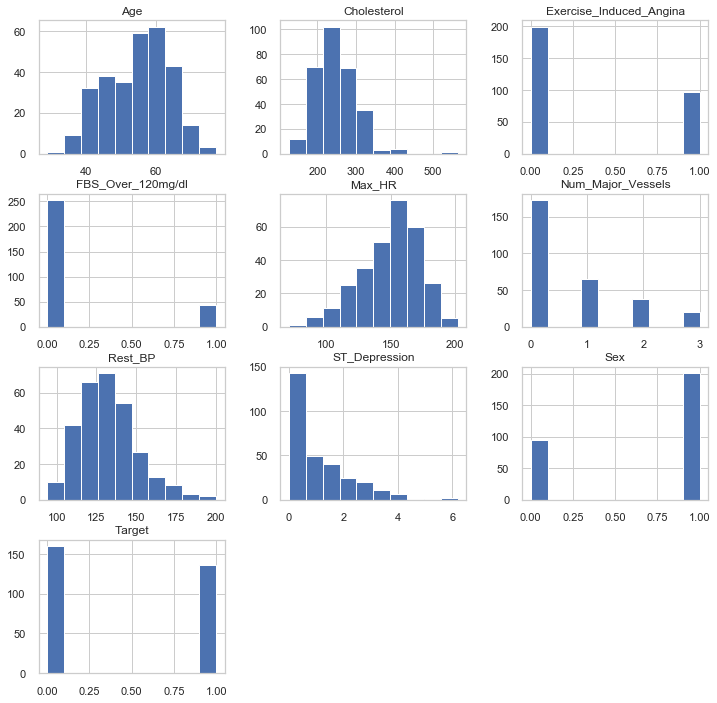

In [277]:
#View feature distributions
df.hist(figsize=(12,12));

Applying log transformations to ST_Depression, Rest_BP, and Cholesterol. Applying square transformation to Max_HR.

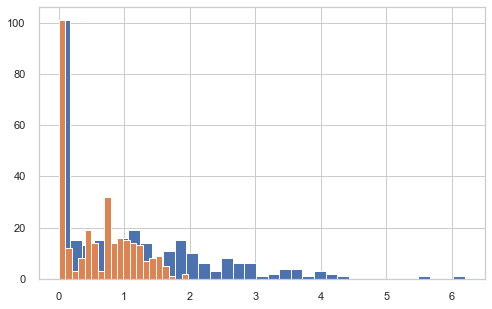

In [278]:
#ST_Depression
fig, ax= plt.subplots(figsize=(8,5))

g = dummies.ST_Depression.hist(bins=35, ax=ax)

k = np.log(dummies['ST_Depression']+1).hist(bins=20, ax=ax)

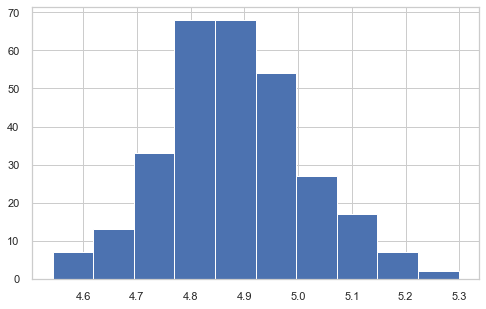

In [279]:
k = np.log(dummies['Rest_BP']).hist(bins=10, figsize=(8,5))

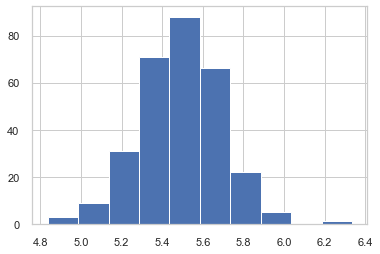

In [280]:
np.log(dummies.Cholesterol).hist()

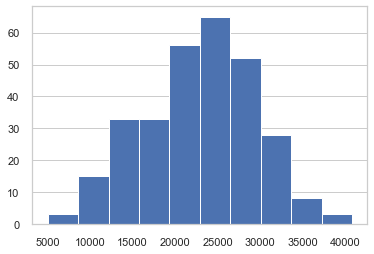

In [281]:
np.square(dummies.Max_HR).hist()
plt.grid(False, axis = 'x')

Apply Transformations

In [282]:
dummies.ST_Depression = np.log(dummies.ST_Depression+1)
dummies.Rest_BP = np.log(dummies.Rest_BP)
dummies.Cholesterol = np.log(dummies.Cholesterol)
dummies.Max_HR= np.square(dummies.Max_HR)

### Split Data

In [283]:
#Seperate training/validation data from target. Convert into arrays
y= dummies.Target
X= dummies.drop(columns=['Target'])

#Check Shape
print('y shape: ',y.shape)
print('X shape: ',X.shape)

y shape:  (296,)
X shape:  (296, 25)


In [284]:
#Import train test split
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(
                                X, y, stratify = y, random_state=0)

# show the distribution
print('Class distribution % for training/test sets')
print(y_train.value_counts(normalize=True) * 100)

print('\nX_train shape: {} y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_test shape: {} y_test shape: {}'.format(X_test.shape, y_test.shape))

Class distribution % for training/test sets
0    54.054054
1    45.945946
Name: Target, dtype: float64

X_train shape: (222, 25) y_train shape: (222,)
X_test shape: (74, 25) y_test shape: (74,)


Model base feature selection

Using a random forest classifier

In [285]:
# #Import 
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import RandomForestClassifier

# #Instantiae selector to remove 25% of lowest pvalue features
# select = SelectFromModel(RandomForestClassifier(n_estimators=100,
#                                            random_state = 42),
#                                            threshold = .01)

# #fit
# select.fit(X_train, y_train)

# #print list of features kept
# selected_feat= X_train.columns[(select.get_support())]
# print(selected_feat)

# #Transform X_train
# X_train = select.transform(X_train)

# #Confirm X_train Shape
# X_train.shape

Reduced from 25 to 19 features

## Metrics for classifier evaluation

For our model, we want to make sure we are limiting the number of false negatives(this means identifying a sick person as healthy). Because our target is fairly balanced, we will evaluate different base models for classification based on performance accuracy on the training data.

Once we have identified the most accurate model, we will then proceed to optimize it's recall performance.

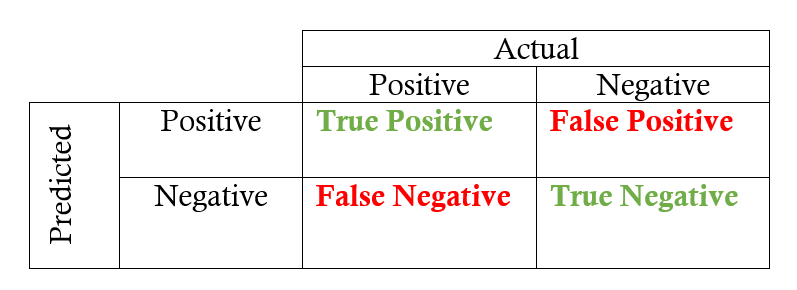

In [286]:
from IPython.display import Image
Image(filename='Beyond Accuracy.png') 

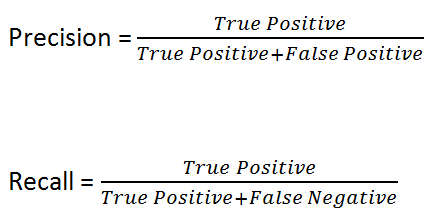

In [287]:
Image(filename='Precision vs Recall.png') 

# Create Pipeline of Base Classification models

We will use the following models to create a pipeline and select the model that performs best to tune.
- Logistic Regression
- KNN
- Decision Tree
- Gradient Boosted Tree
- SVM(linear and rbf)

Building the pipeline

In [288]:
#Import pipeline
from sklearn.pipeline import Pipeline

#Import Scalers
from sklearn.preprocessing import StandardScaler

#Import cross validator to test accuracy of pipe
from sklearn.model_selection import cross_validate

In [289]:
#Summon base model for pipeline
from sklearn.linear_model import LogisticRegression

#Build Pipeline with LogisticRegression
pipe = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('classifier', LogisticRegression()) #step2 - classifier
])
pipe.steps

[('normalizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

In [290]:
#Evaluate pipeline using cross validate, using roc_auc to reduce # of false positives
scores = cross_validate(pipe, X_train, y_train, cv=5,
                        return_train_score=True, scoring="accuracy") #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
#Results
print('Avg Accuracy:',scores['test_score'].mean())

print('\nAll Scores:')
scores

Avg Accuracy: 0.8466666666666667

All Scores:


{'fit_time': array([0.00598407, 0.00802588, 0.00398946, 0.00797844, 0.00501871]),
 'score_time': array([0.00099564, 0.00294423, 0.00199318, 0.00099778, 0.00200033]),
 'test_score': array([0.8       , 0.93333333, 0.77272727, 0.90909091, 0.81818182]),
 'train_score': array([0.88700565, 0.87570621, 0.92134831, 0.88764045, 0.90449438])}

Great performance with our logistic regression model without any tuning. Let's spot check with a few other classification models

In [291]:
#Import additional classification base models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

#Append classifiers to list to set as params for pipeline
classifier = []
classifier.append(KNeighborsClassifier())
classifier.append(DecisionTreeClassifier())
classifier.append(RandomForestClassifier())
classifier.append(GradientBoostingClassifier())
classifier.append(LinearSVC())
classifier.append(SVC())

In [292]:
#Score models with for loop
for classifier in classifier:
    pipe.set_params(classifier=classifier)
    scores = cross_validate(pipe, X_train, y_train,
                            cv=5, return_train_score=True, scoring="accuracy")
    print('--------------------------------------------')
    print(str(classifier))
    print('--------------------------------------------')
    for key, values in scores.items():
        print(key,' mean ', values.mean())
        print(key,' std ', values.std())
    print('Avg Score:',scores['test_score'].mean())


--------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
--------------------------------------------
fit_time  mean  0.005191135406494141
fit_time  std  0.002391799473444728
score_time  mean  0.003990316390991211
score_time  std  0.0006312048486441461
test_score  mean  0.8333333333333334
test_score  std  0.06594033471303536
train_score  mean  0.8828984955246619
train_score  std  0.008060446787645547
Avg Score: 0.8333333333333334
--------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,


C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Of our base classifiers, SVC performed the best with a 88.26% accuracy but we'll go with KNN to save time on training.  We will tune it's hyper parameters to improve its performance on our data using both Random Search and Grid Search Techniques

In [293]:
#Import knn
from sklearn.neighbors import KNeighborsClassifier

#Instantiate model
knn = KNeighborsClassifier(n_jobs=-1)

#Print params of NuSVC to optimize
print('Parameters currently in use for KNeighborsClassifier:')
print(knn.get_params)

Parameters currently in use for KNeighborsClassifier:
<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')>


### Create random grid

In [294]:
#n_neighbors
n_neighbors =[1,3,5,7,9]

algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

weights = ['uniform', 'distance']

# Create the random grid
random_grid = {'n_neighbors': n_neighbors,
               'algorithm': algorithm,
               'weights':weights}

print(random_grid)

{'n_neighbors': [1, 3, 5, 7, 9], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights': ['uniform', 'distance']}


Run Random Search

In [295]:
from sklearn.model_selection import RandomizedSearchCV
#Create random search for LinearSVC() using random_grid
rand_knn = RandomizedSearchCV(knn, param_distributions=random_grid, n_iter=100, random_state=0,
                               scoring= 'accuracy', verbose = 2, cv=10, error_score=0.0,
                                n_jobs=-1)



In [296]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Fit to data
best_model = rand_knn.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\kishe\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.6s finished


In [297]:
#Print best parameters found by the random search
print(best_model.best_params_)

#score
print("The mean accuracy of the model is:",best_model.score(X_train, y_train))

{'weights': 'uniform', 'n_neighbors': 7, 'algorithm': 'auto'}
The mean accuracy of the model is: 0.7612612612612613


In [298]:
#Print best parameters found by the random search
best_model.best_params_

{'weights': 'uniform', 'n_neighbors': 7, 'algorithm': 'auto'}

# Use Grid Search nearest random search parameters

In [299]:
# #Parameters to have grid search explore
# param_grid = [{'weights': ['uniform'],
#              'n_neighbors': [7,9,11],
#              'algorithm':['auto']}]

# #Print param_grid
# print("Paramter grid:\n {}".format(param_grid))

In [300]:
# #Import grid search cv
# from sklearn.model_selection import GridSearchCV

# #Instantiate GridSearchCV
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# #Fit
# grid_search.fit(X_train, y_train)

In [301]:
# #Results on training data
# print("Best parameters: {}".format(grid_search.best_params_))

# #print("CV Scores: {:.2f}".format(grid_search.cv_results_))
# print("Top CV Score: {:.3f}".format(grid_search.best_score_))

In [302]:
#Import confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report


#Store Predictions of GridSearchCV
preds =best_model.predict(X_train)

#Instantiate Confusion Matrix and print matrix
confusion = confusion_matrix(y_train, preds)
print("Confusion Matrix: \n", confusion)
print('\nClassification Report:\n', classification_report(y_train, preds, 
                                                          target_names= ['Healthy', 'Sick']))

Confusion Matrix: 
 [[98 22]
 [31 71]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.76      0.82      0.79       120
        Sick       0.76      0.70      0.73       102

    accuracy                           0.76       222
   macro avg       0.76      0.76      0.76       222
weighted avg       0.76      0.76      0.76       222



Plot ROC and AUC for our SVM

AUC: 75.64%


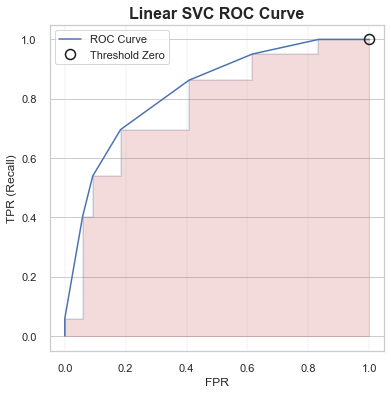

In [303]:
#Import ROC Curve and roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculate AUC
auc = roc_auc_score(y_train, preds)
print('AUC: {:.2%}'.format(auc))

#Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])

#Set Fig Size
fig, ax = plt.subplots(figsize=(6,6))

#Plot ROC Curve
plt.plot(fpr, tpr, label = 'ROC Curve')

#Set plot labels
plt.title('Linear SVC ROC Curve', fontweight='bold', fontsize=16)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')

#Plot threshold closest to 0
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o',
        label= 'Threshold Zero', markersize=10, fillstyle= 'none', c = 'k', mew=1.5)
plt.legend(loc = 'best', frameon=True)

plt.grid(False,lw = .25, axis = 'x')

plt.step(fpr, tpr, color='b', alpha=0.2,
             where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='r');

Optimize Model Recall

In [304]:
#Lower Decision Threshold to increase class 1 recall
pred_lower_threshold = best_model.predict_proba(X_train)[:,1] > .2

#View confusion matrix
confusion = confusion_matrix(y_train, pred_lower_threshold)
print("Confusion Matrix: \n", confusion)

#pring class report
print(classification_report(y_train, pred_lower_threshold))

Confusion Matrix: 
 [[46 74]
 [ 5 97]]
              precision    recall  f1-score   support

           0       0.90      0.38      0.54       120
           1       0.57      0.95      0.71       102

    accuracy                           0.64       222
   macro avg       0.73      0.67      0.62       222
weighted avg       0.75      0.64      0.62       222



AUC: 66.72%


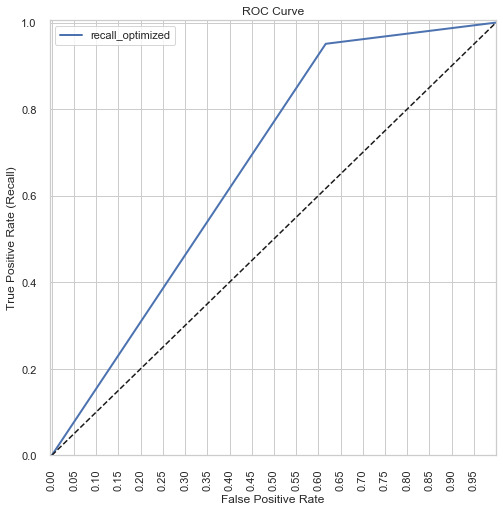

In [305]:
fpr, tpr, auc_thresholds = roc_curve(y_train, pred_lower_threshold)

auc = roc_auc_score(y_train, pred_lower_threshold)
print('AUC: {:.2%}'.format(auc))


def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best', frameon=True)
    
plot_roc_curve(fpr, tpr, 'recall_optimized')
